In [1]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, trange
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [ ]:
### NOTE: model architecture + training methodology taken/adapted from this source.
### https://www.kaggle.com/pankajj/fashion-mnist-with-pytorch-93-accuracy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)

cuda:0
1.8.0a0+52ea372


In [3]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [4]:
"""
    Data loading, train and test set via the PyTorch dataloader.
"""

train_transform=transforms.Compose([
#         transforms.RandomCrop(28, padding=4),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

test_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        ])

batch_size = 100

trainset = datasets.FashionMNIST('./data', train=True, download=True,
                   transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = datasets.FashionMNIST('./data', train=False,
                   transform=test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [5]:
img, label = trainset[0]
img.shape

torch.Size([1, 28, 28])

In [6]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [7]:
num_epochs = 10
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.45291972160339355, Accuracy: 87.86000061035156%
Iteration: 1000, Loss: 0.3269844055175781, Accuracy: 88.0999984741211%
Iteration: 1500, Loss: 0.2898695766925812, Accuracy: 88.18999481201172%
Iteration: 2000, Loss: 0.170387864112854, Accuracy: 89.02999877929688%
Iteration: 2500, Loss: 0.14868588745594025, Accuracy: 90.05999755859375%
Iteration: 3000, Loss: 0.198255717754364, Accuracy: 89.82999420166016%
Iteration: 3500, Loss: 0.2268494963645935, Accuracy: 90.8499984741211%
Iteration: 4000, Loss: 0.22648312151432037, Accuracy: 90.18000030517578%
Iteration: 4500, Loss: 0.10282650589942932, Accuracy: 89.27999877929688%
Iteration: 5000, Loss: 0.15380267798900604, Accuracy: 90.0999984741211%
Iteration: 5500, Loss: 0.1070132702589035, Accuracy: 90.07999420166016%
Iteration: 6000, Loss: 0.11955312639474869, Accuracy: 90.29999542236328%


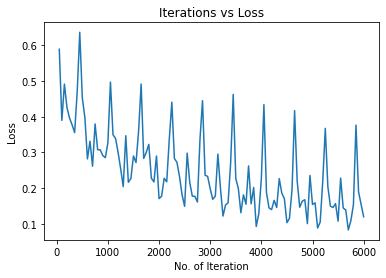

In [8]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

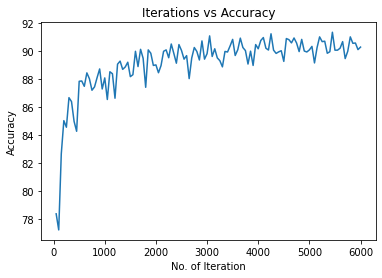

In [9]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [10]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [78]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 90.10%
Accuracy of Trouser: 97.30%
Accuracy of Pullover: 85.90%
Accuracy of Dress: 91.10%
Accuracy of Coat: 77.60%
Accuracy of Sandal: 94.30%
Accuracy of Shirt: 74.90%
Accuracy of Sneaker: 98.40%
Accuracy of Bag: 98.40%
Accuracy of Ankle Boot: 96.20%


In [79]:
torch.save(model.state_dict(), "mnist_fashion_CNN.pt")

In [45]:
import shap 
batch = next(iter(test_loader))
images, labs = batch

In [19]:
background = images[:90]
print(background.type)
background = background.to(device, dtype=torch.float)
test_images = images[90:94]
test_images = test_images.to(device, dtype=torch.float)
print(test_images.shape)
print(background.shape)
e = shap.DeepExplainer(model, background)

<built-in method type of Tensor object at 0x7f17955f8e80>
torch.Size([4, 1, 28, 28])
torch.Size([90, 1, 28, 28])


In [20]:
shap_values = e.shap_values(test_images)

In [21]:
import numpy as np
shap_values = np.asarray(shap_values)
shap_values.shape

(10, 4, 1, 28, 28)

In [72]:
labs[91]

tensor(3)

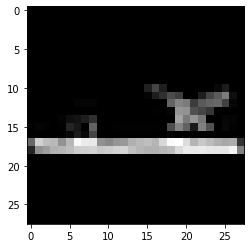

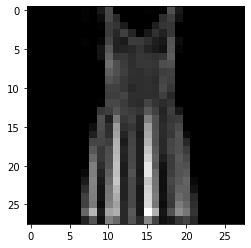

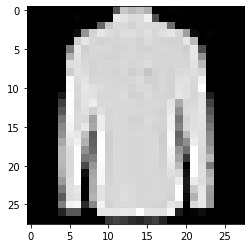

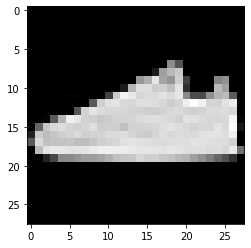

In [37]:
for i in test_images:
    i= i.cpu()
    i = i.numpy()
    plt.imshow(i[0,:,:], cmap='gray')
    plt.show()

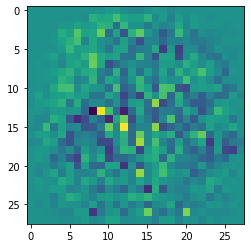

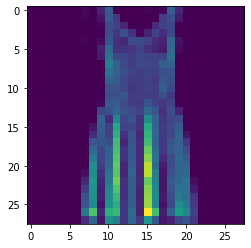

In [39]:
plt.imshow(shap_values[5,1,0,:,:])
plt.show()
plt.imshow(images[91][0,:,:])
plt.show()

(28, 28)
5
(10, 4, 1, 28, 28)
0
(28, 28)


TypeError: Invalid shape (28,) for image data

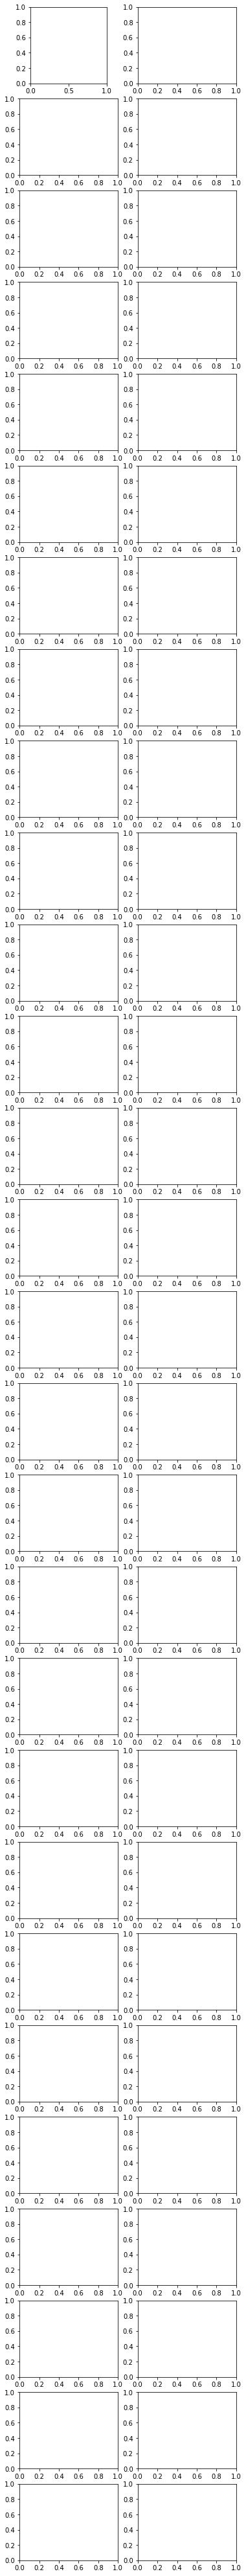

In [65]:
for x in range(len(test_images)):
    i= test_images[x].cpu()
    i = i.numpy()
    i = i[0,:,:]
    print(i.shape)
    true_idx = labs[90+x]
    print(int(true_idx))
    print(shap_values.shape)
    print(x)
    sh = shap_values[int(true_idx),x,0,:,:]
    print(sh.shape)
    shap.image_plot(sh, i)

In [66]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]


In [77]:
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)


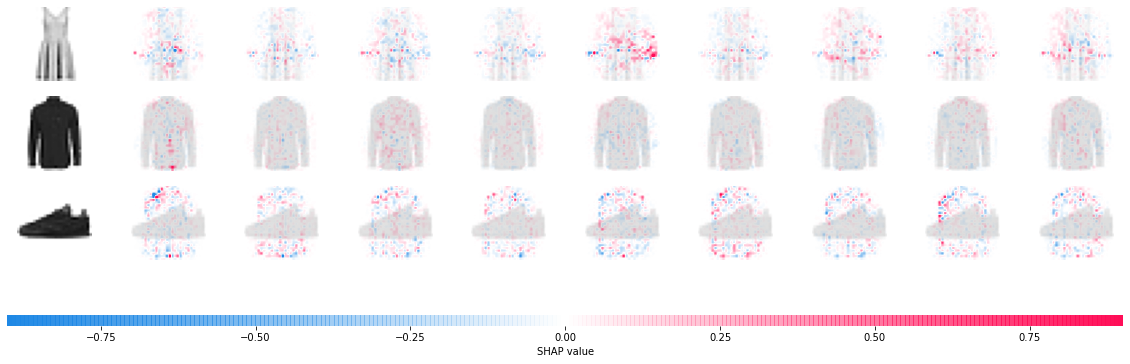

In [75]:
shap.plots.image(shap_numpy[1:], -test_numpy[1:])
